#  **`Sequence-based predictor for the impact of  mutation on protein stability 🧬🧬🧬🧬🧬`**


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
os.chdir('/gdrive/My Drive/MPDS2/projet1')

OSError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install biopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 4.7 MB/s eta 0:00:00


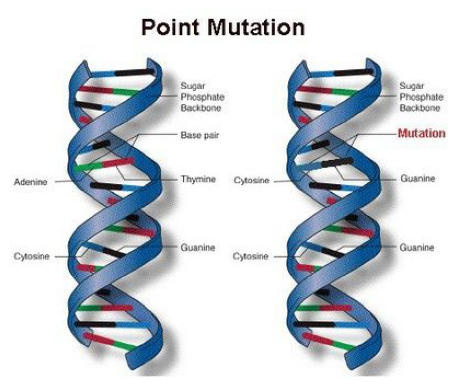

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Charger l'image
image = mpimg.imread("/content/drive/MyDrive/projet1/mutation.jpg")

# Afficher l'image
plt.imshow(image)
plt.axis('off')  # Masquer les axes
plt.show()


### **importation des bibliothèques 📚 :**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from biopandas.pdb import PandasPdb
import plotly.express as px
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

import xgboost
from sklearn.metrics import mean_squared_error as MSE
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [ ]:
!pip install biopandas


In [ ]:
!ls -l

total 8
drwx------ 5 root root 4096 Dec 14 19:23 drive
drwxr-xr-x 1 root root 4096 Dec 13 14:22 sample_data


In [ ]:
PDB_FILE = "1gyz.pdb"

### **Chargement des embeddings**

In [ ]:
# Chargement des embeddings des séquences sauvages (wt) et mutées (mut)
wt_emb = torch.load("train_train_wt.pt")
mut_emb = torch.load("train_train_mut.pt")
df = pd.read_csv("train.csv")
print("Embeddings et Données Chargés avec Succès")

Embeddings et Données Chargés avec Succès


#### **Afficher les premières lignes**

In [ ]:
# Affichage des premiers éléments des tensors
print("Embeddings pour les séquences sauvages (wt) :\n", wt_emb[:5])
print("\nEmbeddings pour les séquences mutées (mut) :\n", mut_emb[:5])

Embeddings pour les séquences sauvages (wt) :
 tensor([[-0.0632,  1.8905,  1.0130,  ...,  1.7288, -2.4825,  0.3187],
        [-0.0632,  1.8905,  1.0130,  ...,  1.7288, -2.4825,  0.3187],
        [-0.0632,  1.8905,  1.0130,  ...,  1.7288, -2.4825,  0.3187],
        [-0.0632,  1.8905,  1.0130,  ...,  1.7288, -2.4825,  0.3187],
        [-0.0632,  1.8905,  1.0130,  ...,  1.7288, -2.4825,  0.3187]])

Embeddings pour les séquences mutées (mut) :
 tensor([[ 0.0070,  1.9001,  1.0074,  ...,  1.6119, -2.3543,  0.3594],
        [ 0.0423,  1.9433,  0.9595,  ...,  1.7695, -2.4142,  0.3128],
        [ 0.0293,  1.9336,  1.0884,  ...,  1.6638, -2.3769,  0.3196],
        [-0.1233,  2.0180,  1.0377,  ...,  1.6911, -2.2926,  0.3670],
        [ 0.0676,  1.9103,  1.0881,  ...,  1.6339, -2.3799,  0.2853]])


In [ ]:
df.head()

### **Analyse de la Distribution de la Colonne 'ddg' - Stabilité des Variantes Protéiques**

Ce code utilise la bibliothèque Plotly pour créer un histogramme illustrant la distribution des valeurs de la colonne 'ddg' à partir d'un DataFrame.

L'histogramme est interprété comme une représentation visuelle de la stabilité des variants protéiques, où des valeurs plus élevées de 'ddg' indiquent une stabilité accrue.

In [ ]:

fig=go.Figure()
colors=["#FFD43B",'#002EFF']

i=0

fig.add_trace(
    go.Histogram(x=df['ddg'],
                 name='ddg',
                 hovertemplate='target column'+'%{y::2f}',
                 marker=dict(color=colors[i])
                )
)
fig.update_xaxes(
        title_text='Target column',
        title_font_color=colors[i],
        tickfont_color=colors[i])
fig.update_yaxes(
        title_text='Frequency',
        title_font_color=colors[i],
        tickfont_color=colors[i])

fig.update_layout(height=800,
                  width=800,
                  title_text='Target Column: Higher ddg means the protien variant is more stable',
                  template="plotly_dark",
                  xaxis=dict(color="#FF9300"),
                  yaxis=dict(color="#FF9300"))
fig.update_traces(marker_line_width=0.1,marker_line_color=colors[1])
fig.show()

NameError: ignored

#### **Analyse de la Longueur des Séquences Sauvages et Mutées - Entraînement**

 l'objectif de cette partie du code est d'examiner la longueur des séquences sauvages et mutées dans l'ensemble de données d'entraînement.

In [ ]:
df['wt_seq_len']=df['wt_seq'].apply(lambda x:len(x))
df['mut_seq_len']=df['mut_seq'].apply(lambda x:len(x))
print('---------TRAIN--------')
display(df[['wt_seq_len','mut_seq_len']].describe())
print('---------TEST--------')
display(df[['wt_seq_len','mut_seq_len']])


---------TRAIN--------


,wt_seq_len,mut_seq_len
count,339778.000000,339778.000000
mean,55.318682,55.318682
std,10.467515,10.467515
min,30.000000,30.000000
25%,43.000000,43.000000
50%,56.000000,56.000000
75%,64.000000,64.000000
max,72.000000,72.000000


---------TEST--------


,wt_seq_len,mut_seq_len
0,59,59
1,59,59
2,59,59
3,59,59
4,59,59
...,...,...
339773,48,48
339774,48,48
339775,48,48
339776,48,48


#### **Histogramme de la Longueur des Séquences Sauvages - Plage entre 25 et 75**
l'histogramme représente la distribution des longueurs des séquences sauvages, avec une plage spécifique entre 25 et 75. Cela offre une visualisation claire de la variabilité des longueurs de séquences dans le DataFrame.

In [ ]:
fig = go.Figure()
colors = ["#FF00F0", "#BD00FF"]

i = 0
# Add one subplot
fig.add_trace(
    go.Histogram(x=df["wt_seq_len"],
               name="wt_seq_len",
               hovertemplate = 'Protein Sequence Length:  %{x:.2f}' + '<br>Frequency: %{y:.2f}</br>',
               marker=dict(color=colors[i])
              )
)
fig.update_xaxes(
    title_text="Protein Sequence Length",
    title_font_color=colors[i],
    tickfont_color=colors[i],
    range=[25, 75]
)
fig.update_yaxes(
    title_text = "Frequency",
    title_font_color=colors[i],
    tickfont_color=colors[i]
)

fig.update_layout(height=800,
                  width=1000,
                  title_text="Wild Type sequence. Length Histogram.",
                  template="plotly_dark",
                  xaxis=dict(color="#FF9300"),
                  yaxis=dict(color="#FF9300"))
fig.update_traces(marker_line_width=2,marker_line_color=colors[1])
fig.show()

# ***Qu’est-ce que le format de fichier PDB¶***
Le format de fichier Protein Data Bank (pdb) est un format de fichier texte décrivant les structures tridimensionnelles des molécules contenues dans la Protein Data Bank. Le format pdb permet donc la description et l'annotation des structures de protéines et d'acides nucléiques, y compris les coordonnées atomiques, les affectations de structures secondaires, ainsi que la connectivité atomique.

La Protein Data Bank (PDB) est une base de données contenant les données structurelles tridimensionnelles de grandes molécules biologiques, telles que les protéines et les acides nucléiques.

In [ ]:

PDB_FILE = "1gyz.pdb"
pdb_df =  PandasPdb().read_pdb(PDB_FILE)
pdb_df.df.keys()


dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [ ]:
def sep():
    print('-'*100)

In [ ]:
atom_df=pdb_df.df['ATOM']
hetatm_df=pdb_df.df['HETATM']
anisou_df=pdb_df.df['ANISOU']
others_df=pdb_df.df['OTHERS']
print(f"ATOM dataset is of shape: {atom_df.shape}"), sep()
print(f"HETATM dataset is of shape: {hetatm_df.shape}"), sep()
print(f"ANISOU dataset is of shape: {anisou_df.shape}"), sep()
print(f"OTHERS dataset is of shape: {others_df.shape}"), sep()

display(atom_df.head())
display(hetatm_df.head())
display(anisou_df.head())
display(others_df.head())

ATOM dataset is of shape: (19460, 21)
----------------------------------------------------------------------------------------------------
HETATM dataset is of shape: (0, 21)
----------------------------------------------------------------------------------------------------
ANISOU dataset is of shape: (0, 21)
----------------------------------------------------------------------------------------------------
OTHERS dataset is of shape: (433, 3)
----------------------------------------------------------------------------------------------------


,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,TRP,,A,59,,...,-3.184,-12.243,0.073,1.0,0.0,,,N,NaN,372
1,ATOM,2,,CA,,TRP,,A,59,,...,-2.435,-10.968,0.095,1.0,0.0,,,C,NaN,373
2,ATOM,3,,C,,TRP,,A,59,,...,-3.076,-10.010,-0.856,1.0,0.0,,,C,NaN,374
3,ATOM,4,,O,,TRP,,A,59,,...,-2.526,-9.669,-1.900,1.0,0.0,,,O,NaN,375
4,ATOM,5,,CB,,TRP,,A,59,,...,-0.938,-11.224,-0.156,1.0,0.0,,,C,NaN,376


,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx


,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,"U(1,1)","U(2,2)","U(3,3)","U(1,2)","U(1,3)","U(2,3)",blank_4,element_symbol,charge,line_idx


,record_name,entry,line_idx
0,HEADER,RIBOSOMAL PROTEIN 02...,0
1,TITLE,BACTERIAL RIBOSOMAL PROTEIN L20 FROM AQUIF...,1
2,COMPND,MOL_ID: 1;,2
3,COMPND,2 MOLECULE: 50S RIBOSOMAL PROTEIN L20;,3
4,COMPND,3 CHAIN: A;,4


Ce code semble être utilisé pour analyser et séparer les différentes parties d'un fichier PDB (Protein Data Bank) en utilisant la bibliothèque BioPandas. Un fichier PDB contient souvent plusieurs types d'informations, tels que les atomes, les hétéroatomes, les facteurs d'anisotropie (ANISOU) et d'autres informations.

En résumé, ce code segmente les informations contenues dans un fichier PDB en quatre parties distinctes (ATOM, HETATM, ANISOU, et OTHERS) et affiche ensuite la forme de chaque partie ainsi qu'un aperçu des premières lignes de données de chaque partie pour une analyse initiale.

In [ ]:
atom_df.columns

Index(['record_name', 'atom_number', 'blank_1', 'atom_name', 'alt_loc',
       'residue_name', 'blank_2', 'chain_id', 'residue_number', 'insertion',
       'blank_3', 'x_coord', 'y_coord', 'z_coord', 'occupancy', 'b_factor',
       'blank_4', 'segment_id', 'element_symbol', 'charge', 'line_idx'],
      dtype='object')

In [ ]:
fig = px.scatter_3d(atom_df, x = "x_coord",
                    y = "y_coord",
                    z = "z_coord",
                    color = "element_symbol",
                    color_discrete_sequence = ["#84FFA9", "#00FFF7", "#003AFF", "#F000FF", "#FBFF00"])
fig.update_traces(marker = dict(size = 3))
fig.update_coloraxes(showscale = False)
fig.update_layout(template = "plotly_dark")
fig.show()

In [ ]:

train_df=df[df['wt_seq_len']<=221]
train_df.reset_index(inplace=True)

In [ ]:
train_df.isnull().sum()

index           0
ID              0
pdb_id          0
mutation        0
wt_aa           0
mutation_pos    0
mut_aa          0
wt_seq          0
mut_seq         0
ddg             0
wt_seq_len      0
mut_seq_len     0
dtype: int64

In [ ]:
# Convert PyTorch tensors to NumPy arrays
wt_emb_np = wt_emb.numpy()
mut_emb_np = mut_emb.numpy()

In [ ]:
df.shape


(339778, 11)

#### **Splitting Data 🪓 :**

In [ ]:

# Diviser les données en ensembles d'entraînement et de test (50% pour chaque ensemble)
wt_emb_train, wt_emb_test, mut_emb_train, mut_emb_test = train_test_split(
    wt_emb_np, mut_emb_np, test_size=0.9, random_state=42)

# Si vous devez également diviser le DataFrame pandas `df` en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df, test_size=0.9, random_state=42)


 ce code prépare les données pour l'entraînement d'un modèle en concaténant les embeddings des séquences sauvages et mutées, puis en divisant ces données en ensembles d'entraînement et de validation. Ces ensembles seront utilisés pour ajuster et évaluer les performances d'un modèle de prédiction de la stabilité des protéines (ddg).

In [ ]:
# Concatenate embeddings
x = np.concatenate([wt_emb_train, mut_emb_train], axis=1)
y = df_train['ddg']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
y_valid

90327    -0.955027
96453    -0.348796
171139   -0.024278
322936   -0.331045
1881     -0.635722
            ...   
90385    -0.164191
292173   -1.599045
288969   -2.517980
156520   -0.222230
305718   -2.131413
Name: ddg, Length: 10194, dtype: float64

In [ ]:
X_train.shape

(23783, 2560)

## **Models 🛠 :**

### **Xgboost**

In [ ]:
# create an xgboost regression model
model = xgboost.XGBRegressor(n_estimators=3, max_depth=7)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:


rmse=np.sqrt(MSE(y_valid,y_pred))
print(rmse)

0.9833919789175924


**Interprétation :**

Le RMSE est une mesure de l'erreur entre les valeurs prédites et les valeurs réelles. Il s'agit essentiellement de la racine carrée de la moyenne des carrés des différences entre les prédictions et les vraies valeurs.
Plus le RMSE est proche de zéro, meilleur est le modèle pour prédire les valeurs cibles.
Dans ce cas précis, le RMSE est d'environ 0.9834, ce qui signifie que, en moyenne, les prédictions diffèrent des vraies valeurs d'environ 0.9834. Il est important de noter que la signification exacte de cette valeur dépend du contexte du problème et des valeurs de la variable cible. Une valeur de RMSE plus basse est généralement préférable, mais cela dépend également du domaine d'application spécifique.

In [ ]:
y_pred[:5]

array([-0.60981   , -0.71631104, -1.6162418 , -0.7956806 , -0.5789467 ],
      dtype=float32)

In [ ]:
stats.spearmanr(y_valid, y_pred)

SignificanceResult(statistic=0.27932383636443114, pvalue=4.651797656361658e-182)

Dans ce cas, le coefficient de corrélation de Spearman (0.279) indique une corrélation positive faible entre y_valid et y_pred, et la valeur p très proche de zéro suggère une forte confiance dans cette corrélation observée.

In [ ]:
submission =pd.DataFrame()
submission['ddg']=y_valid
submission['ddg_pred']=model.predict(X_valid)

submission.to_csv('submission.csv',index=False)

In [ ]:
sub = pd.read_csv('submission.csv')
sub

,ddg,ddg_pred
0,-0.955027,-0.609810
1,-0.348796,-0.716311
2,-0.024278,-1.616242
3,-0.331045,-0.795681
4,-0.635722,-0.578947
...,...,...
10189,-0.164191,-0.609810
10190,-1.599045,-0.884222
10191,-2.517980,-0.878307
10192,-0.222230,-0.663678


### **DecisionTreeRegressor**

In [ ]:

model = DecisionTreeRegressor(max_depth=5)
model = xgboost.XGBRegressor(n_estimators=3, max_depth=7)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_valid)
y_pred

array([-0.60981   , -0.71631104, -1.6162418 , ..., -0.87830734,
       -0.6636776 , -0.95819914], dtype=float32)

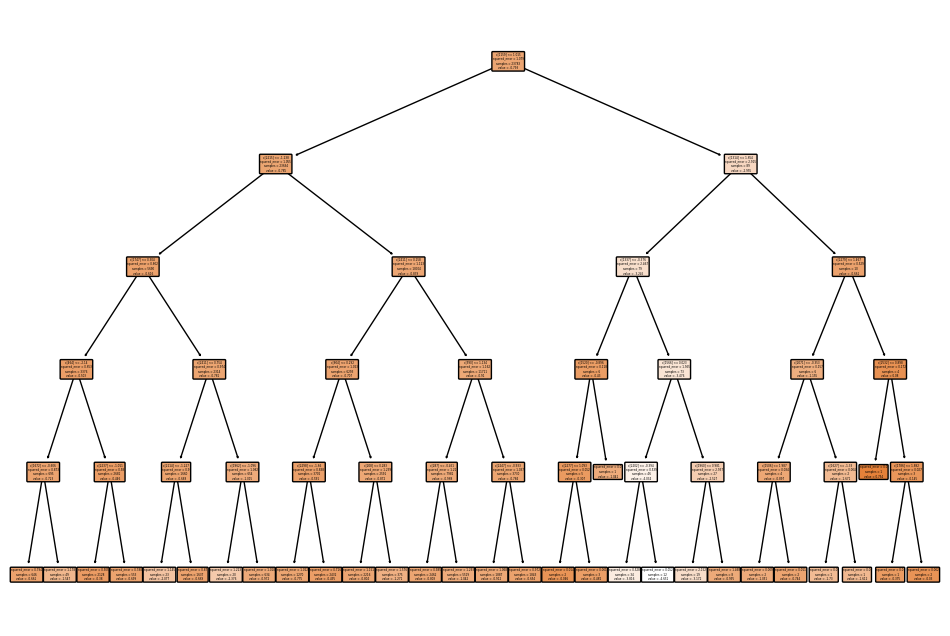

Mean Squared Error: 1.0181106058364136
R-squared: 0.03239892349138784


In [ ]:


# Assuming you have X_train, y_train, X_test, y_test defined

# Create and train the DecisionTreeRegressor model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=None, class_names=None, rounded=True)
plt.show()

# Make predictions on the test set
predictions = model.predict(X_valid)

# Measure performance
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
